### In this notebook, I will be following the post in the [blog](http://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html)

The taks is that given a sequence of input $X_t$, predict output $Y_t$.

$X_t$'s are iid Bernouli random variable.

$Y_t$ is also a binary random variable but its probability distribution depend on $X_t$.
- If $X_{t - 3} = 0$ and $X_{t - 8} = 0$, probability of $Y_t = 1$ is $0.5$. 
- If $X_{t - 3} = 0$ and $X_{t - 8} = 1$, probability of $Y_t = 1$ is $0.25$.
- If $X_{t - 3} = 1$ and $X_{t - 8} = 0$, probability of $Y_t = 1$ is $1.0$.
- If $X_{t - 3} = 1$ and $X_{t - 8} = 1$, probability of $Y_t = 1$ is $0.75$.

The probability of the output is $1$ is 
$$P(Y = 1) = 0.25\times (0.5 + 0.25 + 1 + 0.75) = 0.625$$

The cross-entropy loss that we should expect in this case can be calculated as following: 

If our model does not learn any time dependencies, the error we will get will be approxiamtely equal to 
$$
- P(Y = 1) \log P(\hat{Y} = 1) - P(Y = 0) \log P(\hat{Y} = 0) 
= 
-0.625 \log(0.625) - 0.375 \log(0.375) 
= 0.6615
$$ 

If our model learns the first time-dependencies, then it will predict the target is $1$ based on the third input. 
\begin{eqnarray}
P(X_{-3} = 0) \left(- P(Y = 1 | X_{-3} = 0) \log P(\hat{Y} = 1 | X_{-3} = 0) - P(Y = 0 | X_{-3} = 0) \log P(\hat{Y} = 0 | X_{-3} = 0)\right) + P(X_{-3} = 1) \left(- P(Y = 1 | X_{-3} = 1) \log P(\hat{Y} = 1 | X_{-3} = 1) - P(Y = 0 | X_{-3}   1) \log P(\hat{Y} = 0 | X_{-3} = 1)\right) \\
= 0.5 \left(- 0.375 \log(0.375) - 0.625 \log(0.625) \right) + 0.5 \left(- 0.875 \log(0.875) - 0.125 \log(0.125) \right) \\
= 0.52
\end{eqnarray}

If our model learns both the time-dependencies, then the cross entropy error we will get is
$$
0.25 \left(\log(0.5) + \left(-0.25 \log(0.25) - 0.75 \log(0.75)\right) + 0 + \left(-0.25 \log(0.25) - 0.75 \log(0.75)\right)\right)
= 0.45445
$$

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Input

In [2]:
batch_size = 200
data_size = 1000000
num_classes = 2

In [3]:
def gen_data(data_size=data_size):
    """Return the X and Y sequence generated according the rule described
    above
    """
    x = np.random.choice(2, size=(data_size,))
    y = []
    for i in xrange(data_size):
        threshold = 0.5
        if x[i - 3] == 1:
            threshold += 0.5
        if x[i - 4] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            y.append(0)
        else:
            y.append(1)
    return x, np.array(y)

In [4]:
def gen_batch(raw_data, batch_size, num_steps):
    """Return a generator for producing the input sequence and target sequence for rnn
    """
    x, y = raw_data
    
    size = len(x)
    column_size = size // batch_size
    
    data_x = np.zeros((batch_size, column_size), dtype = np.int32)
    data_y = np.zeros((batch_size, column_size), dtype = np.int32)
    
    for i in xrange(batch_size):
        data_x[i] = x[i * column_size:(i + 1) * column_size]
        data_y[i] = y[i * column_size:(i + 1) * column_size]
        
    num_epochs = column_size // num_steps
    
    for i in xrange(num_epochs):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]    
        yield (x, y)
        
def gen_epoch(n, batch_size, num_steps):
    """Return a generator that gives data for N epochs
    """
    for i in xrange(n):
        data = gen_data()
        yield gen_batch(data, batch_size, num_steps)

In [5]:
#### Testing for an Epoch 
epoch = gen_epoch(1, data_size, 1)
batches = next(epoch)
batch = next(batches)

In [6]:
#### The amount of one in ys should be close to 0.66
#### The amount of one in xs should be close to 0.5 
print "The average ones in Xs are {}".format((batch[0] == 1).mean())
print "The average ones in Ys are {}".format((batch[1] == 1).mean())

The average ones in Xs are 0.500602
The average ones in Ys are 0.625322


### RNN model

In [7]:
def create_variables(state_size, num_classes):
    """Create variables for RNN
    """
    with tf.variable_scope("rnn"):
        W = tf.get_variable("W", [num_classes + state_size, state_size])
        b = tf.get_variable("b", [state_size], initializer=tf.constant_initializer(0))
    
    with tf.variable_scope("softmax"):
        W_softmax = tf.get_variable("W_softmax", [state_size, num_classes])
        b_softmax = tf.get_variable("b_softmax", [num_classes], 
                                   initializer=tf.constant_initializer(0))

In [8]:
def rnn(input_, state, state_size, num_classes):
    """ Creating a model for RNN
    """
    with tf.variable_scope("rnn", reuse=True):
        W = tf.get_variable("W", [num_classes + state_size, state_size], 
                            initializer=tf.truncated_normal_initializer())
        b = tf.get_variable("b", [state_size], initializer=tf.constant_initializer(0))
        return tf.tanh(tf.matmul(tf.concat(1, [input_, state]), W) + b)

In [9]:
def rnn_loop(rnn_inputs, init_state, state_size, num_classes):
    state = init_state
    outputs = []
    for x in rnn_inputs:
        state = rnn(x, state, state_size, num_classes)
        outputs.append(state)
    return outputs

In [10]:
def softmax(outputs, state_size, num_classes):
    with tf.variable_scope("softmax", reuse=True):
        W_softmax = tf.get_variable("W_softmax", [state_size, num_classes])
        b_softmax = tf.get_variable("b_softmax", [num_classes], 
                                   initializer=tf.constant_initializer(0))
        logits = [tf.matmul(o, W_softmax) + b_softmax for o in outputs]
        probabilities = [tf.nn.softmax(l) for l in logits]
    return logits
            

In [11]:
def loss(logits, y_target):
    return tf.reduce_mean([tf.nn.sparse_softmax_cross_entropy_with_logits(l, y_target[:, i])
            for i, l in enumerate(logits)])

In [12]:
def train(n_epoch=1, batch_size=200, num_steps=10, learning_rate=0.1, state_size=5):
    
    #### create placeholders
    x_input = tf.placeholder(tf.int32, shape=(batch_size, num_steps))
    y_target = tf.placeholder(tf.int32, shape=(batch_size, num_steps))
    init_state = tf.placeholder(tf.float32, shape=(batch_size, state_size))   
    x_one_hot = tf.one_hot(x_input, num_classes)
    rnn_inputs = tf.unpack(x_one_hot, axis=1)

    # Parameters for RNN
    init_state_value = np.zeros((batch_size, state_size))
    
    #creating the model
    create_variables(state_size, num_classes)
    outputs = rnn_loop(rnn_inputs, init_state, state_size, num_classes)
    final_state = outputs[-1]
    training_loss = loss(softmax(outputs, state_size, num_classes), y_target)
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(training_loss)

    #Training the model
    #with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    losses = []

    for itr_epoch, epoch in enumerate(gen_epoch(n_epoch, batch_size=batch_size, num_steps=num_steps)):
        print "EPOCH: {}".format(itr_epoch)
        for itr_batch, (_x, _y) in enumerate(epoch): 
            init_state_value, loss_, _ = sess.run([final_state, training_loss, train_op], 
                                                  {x_input: _x, y_target: _y, init_state: init_state_value})
            if itr_batch % 100 == 0:
                losses.append(loss_)
                
    return losses


In [13]:
sess = tf.InteractiveSession()
losses = train(n_epoch=5, learning_rate=0.001, state_size=5, num_steps=12)

EPOCH: 0
EPOCH: 1
EPOCH: 2
EPOCH: 3
EPOCH: 4


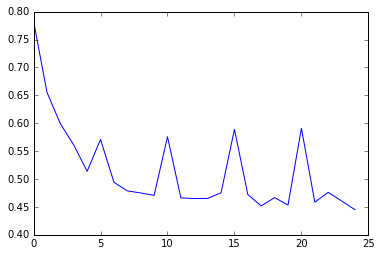

In [14]:
plt.plot(losses)

In [15]:
softmax_W, softmax_b = tf.get_collection("variables", scope="softmax")[0:2]
softmax_W = softmax_W.eval()
softmax_b = softmax_b.eval()

In [16]:
rnn_W, rnn_b =  tf.get_collection("variables", scope="rnn")[0:2]
rnn_W = rnn_W.eval()
rnn_b = rnn_b.eval()

In [22]:
# Input parameters
num_steps = 12
batch_size = 1
state_size = 5
def test(xs):
    x_input = tf.placeholder(tf.int32, shape=(batch_size, num_steps))
    y_target = tf.placeholder(tf.int32, shape=(batch_size, num_steps))
    init_state = tf.placeholder(tf.float32, shape=(batch_size, state_size))   
    x_one_hot = tf.one_hot(x_input, num_classes)
    rnn_inputs = tf.unpack(x_one_hot, axis=1)

    # Parameters for RNN
    init_state_value = np.zeros((batch_size, state_size))

    #creating the model
    outputs = rnn_loop(rnn_inputs, init_state, state_size, num_classes)
    final_state = outputs[-1]

    #Testing the model
    #with tf.Session() as sess:
    states = []
    for _x in xs: 
        init_state_value, states_ = sess.run([final_state, outputs], 
                                             {x_input: _x, init_state: init_state_value})
        states.append(states_)
    return states

In [23]:
def plot_test(states):
    combined_states = np.concatenate([np.concatenate(state) for state in states])
    plt.plot(combined_states)
    plt.legend(["state-0", "state-1", "state-2", "state-3", "state-4"], loc="center")
    plt.show()

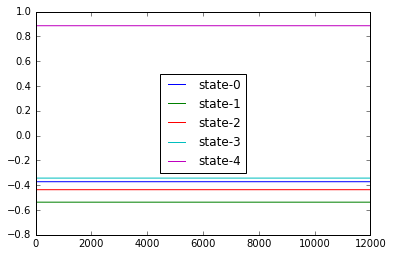

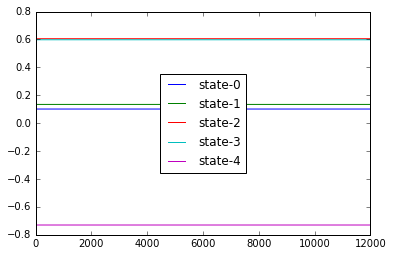

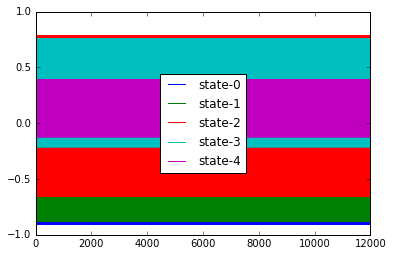

In [29]:
xs1 = [np.ones((batch_size, num_steps)) for _ in range(1000)]
xs2 = [np.zeros((batch_size, num_steps)) for _ in range(1000)]
xs3 = [np.array([[1, 0, 0] * 4]) for _ in range(1000)]

for xs in [xs1, xs2, xs3]:
    plot_test(test(xs))

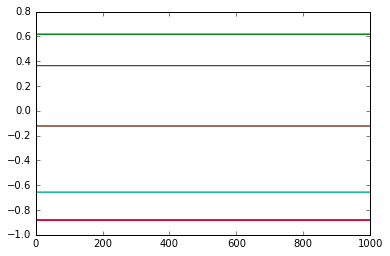

In [41]:
# In the last example, all the time stamps that receives 1 input
plt.plot(np.concatenate([t1[0] for t1 in t]))
plt.plot(np.concatenate([t1[3] for t1 in t]))
plt.plot(np.concatenate([t1[6] for t1 in t]))
plt.plot(np.concatenate([t1[9] for t1 in t]))
print 

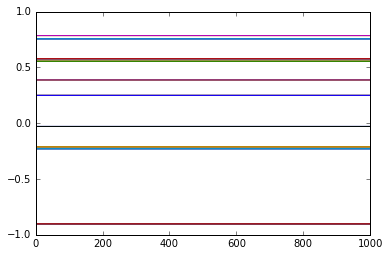

In [42]:
# In the last example, all the time stamps that receives 1 input
for i in [1, 2, 4, 5, 7, 8, 10, 11]: 
    plt.plot(np.concatenate([t1[i] for t1 in t]))